In [51]:
!pip install tqdm

import urllib.request
import zipfile
import os
from tqdm import tqdm

# Function to download a file with a progress bar
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

#url = "https://nlp.stanford.edu/data/glove.6B.zip"
#output = "glove.6B.zip"

# Download the GloVe embeddings with a progress bar
#with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
    #urllib.request.urlretrieve(url, filename=output, reporthook=t.update_to)


# Unzip the downloaded file
#with zipfile.ZipFile(output, 'r') as zip_ref:
    #zip_ref.extractall()

# Ensure gensim is installed
#!pip install gensim

# Import KeyedVectors from gensim and load the word vectors
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('glove.6B.50d.txt', binary=False, no_header=True)

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\Student\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [52]:
#!pip install torch torch-geometric
#!pip install pandas
#!pip install scikit-learn
!pip install matplotlib

import pandas as pd
import os
from collections import defaultdict, Counter
import torch
import torch.nn as nn
import numpy as np

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, r2_score, mean_squared_error
import matplotlib.pyplot as plt
torch.manual_seed(42)

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\Student\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [53]:
!unzip drive/MyDrive/slt_challenge/transcripts_outputFiles.zip


'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [54]:
def load_graph_info(nodes_degree_txt, nodes_edges_txt):
  nodes_features = defaultdict(dict)
  edges = []
  with open(nodes_degree_txt, 'r') as nodes_degree_file, open(nodes_edges_txt, 'r') as nodes_edges_file:
      reading_nodes, reading_edges = False, False

      for line in nodes_edges_file:
          line = line.strip()
          if (not line) or line.startswith("id*int") or line.startswith("source*int"):
              continue

          if line.startswith("*Nodes"):
              # start reading node info
              reading_nodes = True
              reading_edges = False
          elif line.startswith("*DirectedEdges"):
              # start reading edge info
              reading_nodes = False
              reading_edges = True

          elif reading_nodes:
            # parse node info
              parts = line.split(" ", 2)
              node_id = int(parts[0])
              label = parts[1].strip('"')
              nodes_features[node_id]['label'] = label


          elif reading_edges:
            # parse edge info
              parts = line.split()
              source = int(parts[0])
              target = int(parts[1])
              edges.append((source, target))

      for line in nodes_degree_file:
        line = line.strip()
        if (not line) or (not line.startswith("Node Degree")):
          parts = line.split()
          node_id = int(parts[0])
          degree = parts[1].strip('"')
          nodes_features[node_id]['degree'] = degree

      # print(len(nodes_features), len(edges))
      return nodes_features, edges


def get_word_embedding(word, embedding_dim=50):
    try:
        return torch.tensor(word_vectors[word], dtype=torch.float)
    except KeyError:
        # for words not in the vocabulary, use a zero vector
        # print('WARNING: word not in the vocabulary: ', word)
        return torch.zeros(embedding_dim)


def prep_data_for_gnn(nodes_features, edges):
    # mapping from node ID to index
    node_id_to_index = {node_id: i for i, node_id in enumerate(nodes_features.keys())}

    # create node features: node degrees and word embeddings)
    features = []
    for node_id in nodes_features.keys():
        node_label = nodes_features[node_id]['label']
        node_embeddings = get_word_embedding(node_label)
        # print(node_id,nodes_features[node_id]['degree'])
        # new_value = torch.tensor([15], dtype=torch.int64)
        # tensor = torch.cat((node_embeddings, new_value))

        features.append(node_embeddings)
    x = torch.stack(features)  # Node feature matrix

    # create edge index tensor
    edge_index = torch.tensor(
        [[node_id_to_index[src], node_id_to_index[dst]] for src, dst in edges],
        dtype=torch.long,
    ).t().contiguous()
    return x, edge_index


def get_datalist(id_list, label_list, transcript_folder):
  """
  returns a list of Data objects
  """
  data_list = []
  id_label_list = [(id, label) for id, label in zip(id_list, label_list)]
  for id, label in id_label_list:
    filepath = os.path.join(transcript_folder, id)
    nodes_features, edges = load_graph_info(f'{filepath}_dir_nodes_degree.txt', f'{filepath}_dir_nodes_edges.txt')
    x, edge_index = prep_data_for_gnn(nodes_features, edges)
    graph_data = Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))
    data_list.append(graph_data)
  return data_list


def get_dataloader(data_list, batch_size=None):
  if not batch_size:
    batch_size = len(data_list)
    print('Setting batch size to ', batch_size)
  return DataLoader(data_list, batch_size=batch_size, shuffle=False)


class GNNClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x


def train_gnn(train_datalist, train_batch_size=None, hidden_dim=64, lr=0.01, epoches=250):
  torch.manual_seed(42)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  train_dataloader = get_dataloader(train_datalist, batch_size=train_batch_size)
  num_node_features = next(iter(train_dataloader)).x.size(1)
  num_classes = pd.Series([data.y for data in train_datalist]).nunique()
  model = GNNClassifier(input_dim=num_node_features, hidden_dim=hidden_dim, output_dim=num_classes).to(device)
  optimizer = Adam(model.parameters(), lr=lr)

  # Train
  for epoch in range(epoches):  # train for 50 epochs
      model.train()
      total_loss = 0

      for batch in train_dataloader:
          batch = batch.to(device)
          optimizer.zero_grad()
          out = model(batch)
          loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.5f}')

  return model


def eval_gnn(model, eval_datalist, stage_labels=None, print_results=True, batch_size=None):
    model.eval()
    logits_list, pred_list, y_list = [], [], []
    eval_dataloader = get_dataloader(eval_datalist, batch_size=batch_size)
    for batch in eval_dataloader:
        logits = model(batch)
        pred = logits.argmax(dim=1)
        logits_list.append(logits)
        pred_list.append(pred)
        y_list.append(batch.y)
    # concatenate data from all batches
    logits_all = torch.cat(logits_list, dim=0)
    pred_all = torch.cat(pred_list, dim=0)
    y_all = torch.cat(y_list, dim=0)
    # get metrics
    results, disp = calc_metrics(y_all, pred_all, display_labels=stage_labels)
    return logits_all, pred_all, results, disp

def calc_metrics(actual_labels, pred_vals, display_labels=None, print_results=True):
    results = {
        'accuracy': accuracy_score(actual_labels, pred_vals),
        'f1': f1_score(actual_labels, pred_vals, average='macro'),
        'precision': precision_score(actual_labels, pred_vals, average='macro'),
        'recall': recall_score(actual_labels, pred_vals, average='macro')
    }

    cm = confusion_matrix(actual_labels, pred_vals)

    # Get only the unique classes present in the actual predictions
    unique_classes = np.unique(np.concatenate([actual_labels, pred_vals]))  
    if display_labels is None:
        display_labels = [str(label) for label in unique_classes]  # Ensure matching labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

    if print_results:
        for metric, value in results.items():
            print(f'{metric}: {value:.3f}')
        disp.plot()
        plt.show()

    return results, disp


class NNMetaModel(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
      super().__init__()
      self.fc1 = Linear(input_dim, hidden_dim)
      self.fc2 = Linear(hidden_dim, output_dim)

  def forward(self, x):
      x = self.fc1(x)
      x = x.relu()
      x = self.fc2(x)
      return x

def train_nn_metamodel(features, labels, epochs=50, hidden_dim=32, lr=0.01, n_tasks=3):
    num_classes = len(torch.unique(labels))
    input_dim = features.shape[1]
    model = NNMetaModel(input_dim, hidden_dim=hidden_dim, output_dim=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(features)
        loss = cross_entropy(output, labels)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
    return model


Fold 0:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 48}),
    train set for meta model: 25 samples; label count: Counter({0: 13, 1: 12}),
    dev set for meta model: 32 samples; label count: Counter({0: 17, 1: 15})
----------- Task: CTD -----------
Training base model for Healthy vs. Non-Healthy...
Setting batch size to  100
Epoch 0, Loss: 3.73165


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.57239
Epoch 100, Loss: 0.23089
Epoch 150, Loss: 0.03610
Epoch 200, Loss: 0.00794
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.560
f1: 0.548
precision: 0.559
recall: 0.554


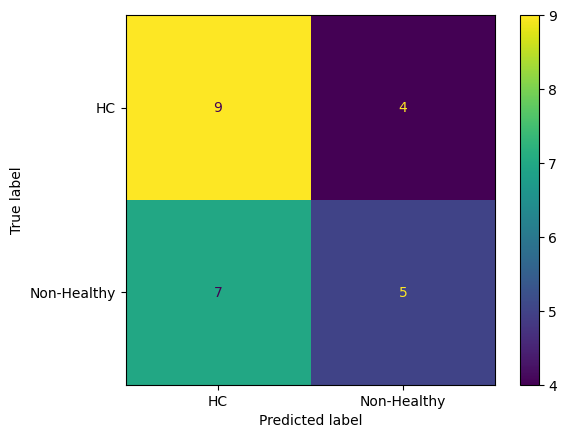

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.406
f1: 0.391
precision: 0.392
recall: 0.398


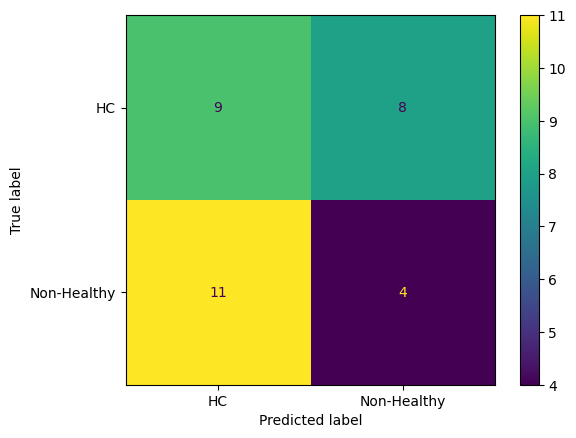

Non-healthy train indices: [0, 3, 5, 7, 13, 15, 16, 17, 18]
Non-healthy dev indices: [0, 1, 3, 7, 8, 13, 15, 16, 17, 20, 25, 26]
Training base model for MCI vs. Dementia...
Setting batch size to  5
Epoch 0, Loss: 1.12006


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.00003
Epoch 100, Loss: 0.00001
Epoch 150, Loss: 0.00001
Epoch 200, Loss: 0.00001
Validating on meta model dev set...
Setting batch size to  6
accuracy: 0.667
f1: 0.400
precision: 0.400
recall: 0.400


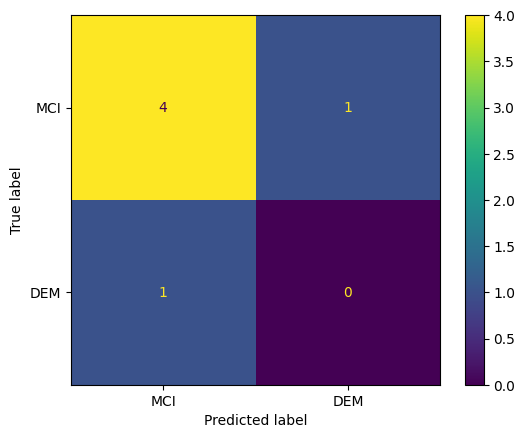

----------- Task: SFT -----------
Training base model for Healthy vs. Non-Healthy...
Setting batch size to  100
Epoch 0, Loss: 3.73943


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.49432
Epoch 100, Loss: 0.07956
Epoch 150, Loss: 0.00722
Epoch 200, Loss: 0.00282
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.520
f1: 0.519
precision: 0.519
recall: 0.519


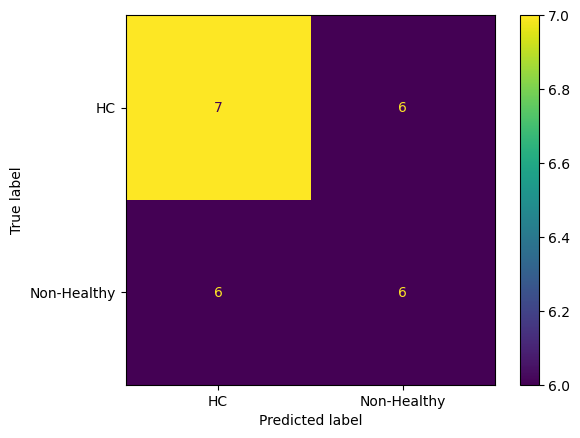

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.719
f1: 0.718
precision: 0.719
recall: 0.720


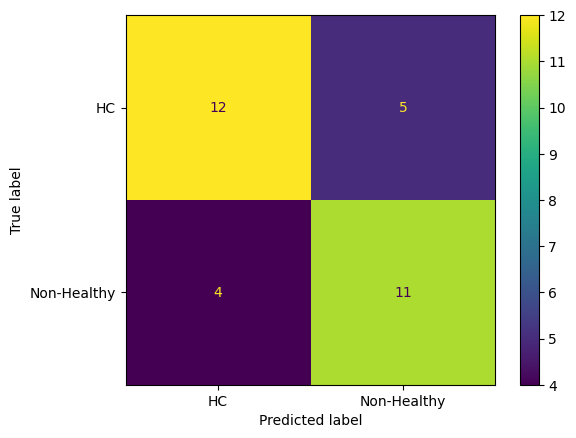

Non-healthy train indices: [0, 4, 5, 6, 7, 11, 12, 14, 15, 16, 19, 21]
Non-healthy dev indices: [1, 5, 7, 11, 12, 13, 14, 17, 18, 19, 20, 21, 23, 24, 28, 31]
Training base model for MCI vs. Dementia...
Setting batch size to  6
Epoch 0, Loss: 1.34446


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.00002
Epoch 100, Loss: 0.00001
Epoch 150, Loss: 0.00001
Epoch 200, Loss: 0.00000
Validating on meta model dev set...
Setting batch size to  4
accuracy: 0.250
f1: 0.200
precision: 0.500
recall: 0.125


C:\Users\Student\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


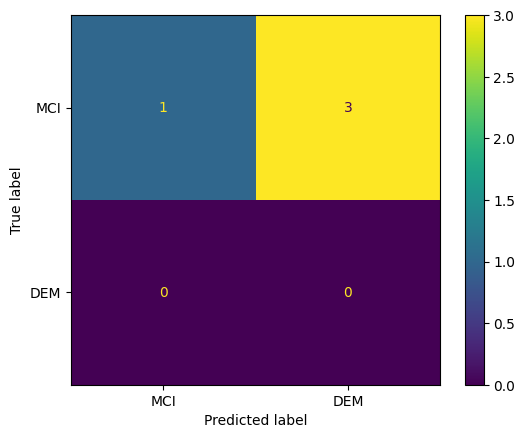

----------- Task: PFT -----------
Training base model for Healthy vs. Non-Healthy...
Setting batch size to  100
Epoch 0, Loss: 3.99761


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.22212
Epoch 100, Loss: 0.00426
Epoch 150, Loss: 0.00125
Epoch 200, Loss: 0.00068
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.600
f1: 0.599
precision: 0.599
recall: 0.599


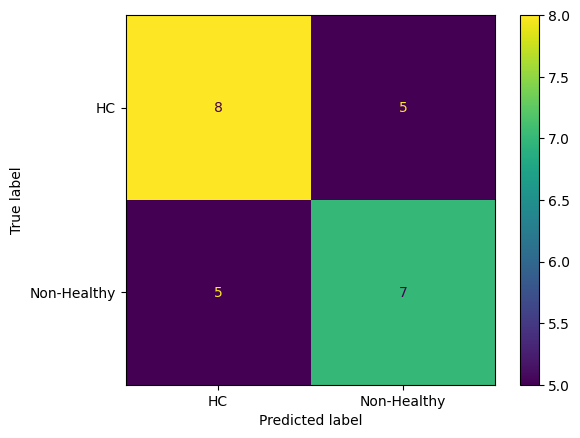

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.594
f1: 0.584
precision: 0.592
recall: 0.586


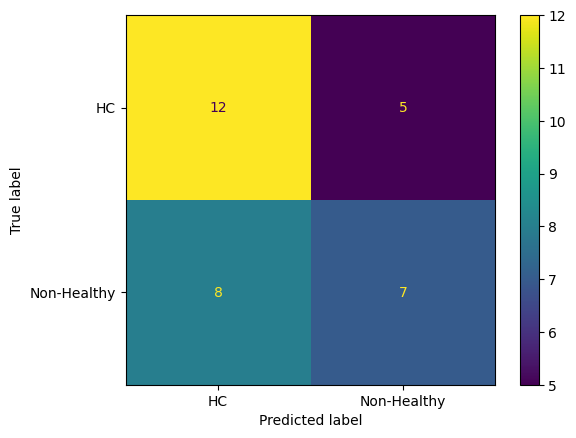

Non-healthy train indices: [1, 3, 6, 7, 10, 12, 17, 18, 20, 21, 23, 24]
Non-healthy dev indices: [0, 1, 3, 5, 13, 16, 18, 19, 21, 23, 28, 30]
Training base model for MCI vs. Dementia...
Setting batch size to  7
Epoch 0, Loss: 0.00000


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.00000
Epoch 100, Loss: 0.00000
Epoch 150, Loss: 0.00000
Epoch 200, Loss: 0.00000
Validating on meta model dev set...
Setting batch size to  5
accuracy: 0.800
f1: 0.444
precision: 0.400
recall: 0.500


C:\Users\Student\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


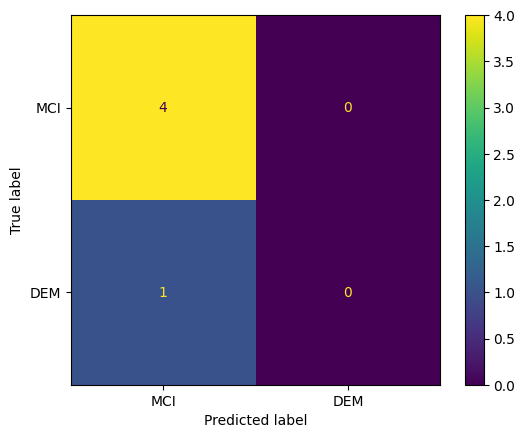

Fold 1:

    train set for base model: 100 samples; label count: Counter({0: 51, 1: 49}),
    train set for meta model: 25 samples; label count: Counter({0: 13, 1: 12}),
    dev set for meta model: 32 samples; label count: Counter({0: 18, 1: 14})
----------- Task: CTD -----------
Training base model for Healthy vs. Non-Healthy...
Setting batch size to  100
Epoch 0, Loss: 3.69920


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.58786
Epoch 100, Loss: 0.25426
Epoch 150, Loss: 0.03574
Epoch 200, Loss: 0.00679
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.440
f1: 0.439
precision: 0.439
recall: 0.439


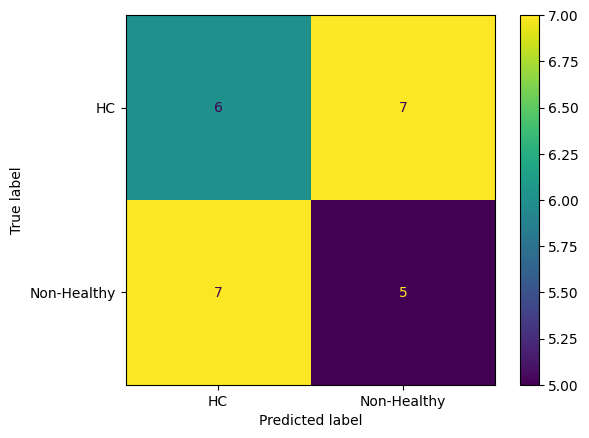

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.438
f1: 0.429
precision: 0.429
recall: 0.429


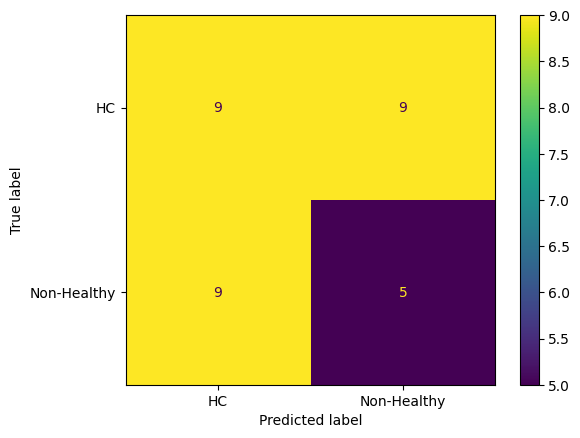

Non-healthy train indices: [2, 3, 4, 5, 6, 8, 9, 11, 18, 21, 23, 24]
Non-healthy dev indices: [1, 2, 3, 4, 5, 7, 11, 14, 16, 18, 22, 27, 30, 31]
Training base model for MCI vs. Dementia...
Setting batch size to  5
Epoch 0, Loss: 0.00000


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.00000
Epoch 100, Loss: 0.00000
Epoch 150, Loss: 0.00000
Epoch 200, Loss: 0.00000
Validating on meta model dev set...
Setting batch size to  4
accuracy: 0.750
f1: 0.429
precision: 0.375
recall: 0.500


C:\Users\Student\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


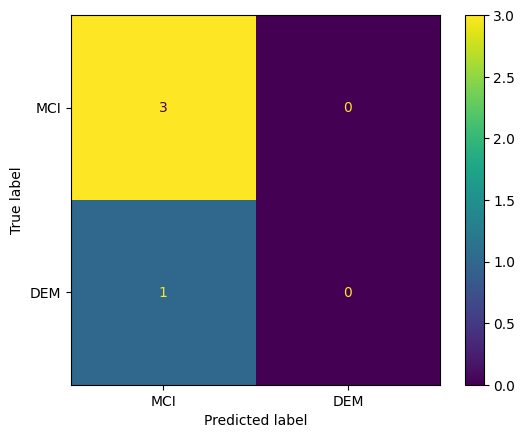

----------- Task: SFT -----------
Training base model for Healthy vs. Non-Healthy...
Setting batch size to  100
Epoch 0, Loss: 3.86888


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.46643
Epoch 100, Loss: 0.08888
Epoch 150, Loss: 0.00742
Epoch 200, Loss: 0.00253
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.400
f1: 0.400
precision: 0.401
recall: 0.401


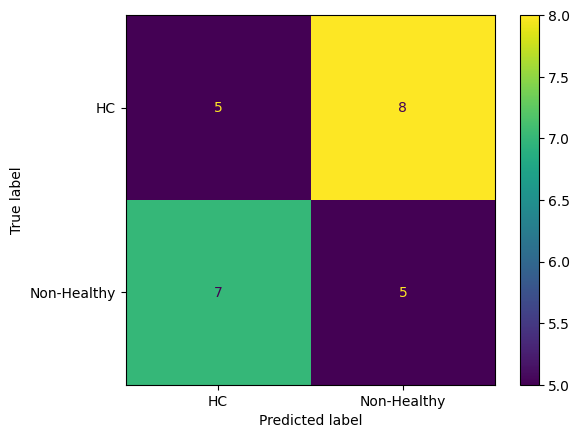

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.625
f1: 0.611
precision: 0.617
recall: 0.611


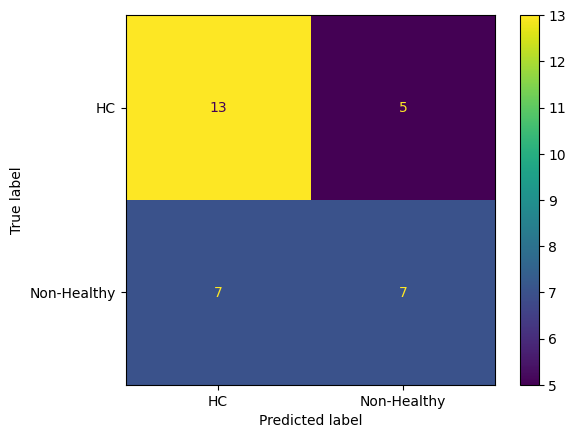

Non-healthy train indices: [0, 2, 3, 7, 9, 10, 11, 12, 13, 14, 15, 16, 21]
Non-healthy dev indices: [2, 5, 7, 8, 17, 18, 20, 21, 22, 27, 28, 30]
Training base model for MCI vs. Dementia...
Setting batch size to  5
Epoch 0, Loss: 0.00000


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.00000
Epoch 100, Loss: 0.00000
Epoch 150, Loss: 0.00000
Epoch 200, Loss: 0.00000
Validating on meta model dev set...
Setting batch size to  6
accuracy: 0.833
f1: 0.455
precision: 0.417
recall: 0.500


C:\Users\Student\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


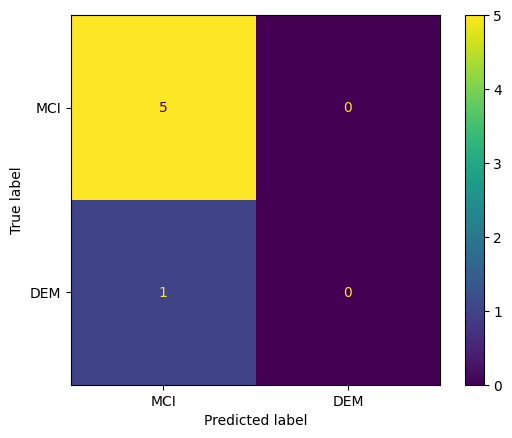

----------- Task: PFT -----------
Training base model for Healthy vs. Non-Healthy...
Setting batch size to  100
Epoch 0, Loss: 3.62435


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.16510
Epoch 100, Loss: 0.00265
Epoch 150, Loss: 0.00098
Epoch 200, Loss: 0.00057
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.520
f1: 0.513
precision: 0.528
recall: 0.526


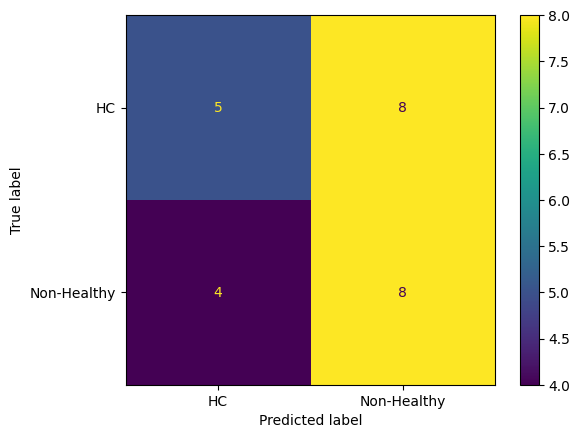

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.562
f1: 0.547
precision: 0.625
recall: 0.595


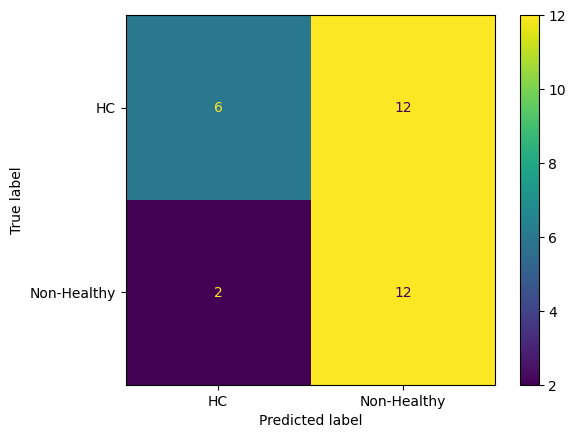

Non-healthy train indices: [1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 15, 17, 18, 21, 22, 24]
Non-healthy dev indices: [0, 1, 3, 4, 5, 7, 8, 9, 11, 13, 14, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 31]
Training base model for MCI vs. Dementia...
Setting batch size to  8
Epoch 0, Loss: 0.72690


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.00000
Epoch 100, Loss: 0.00000
Epoch 150, Loss: 0.00000
Epoch 200, Loss: 0.00000
Validating on meta model dev set...
Setting batch size to  10
accuracy: 0.900
f1: 0.804
precision: 0.944
recall: 0.750


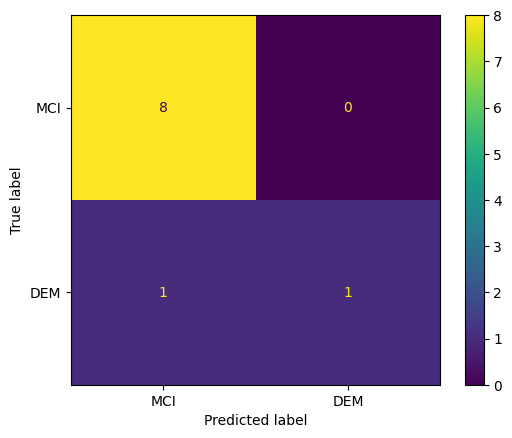

Fold 2:

    train set for base model: 100 samples; label count: Counter({0: 54, 1: 46}),
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 12}),
    dev set for meta model: 31 samples; label count: Counter({1: 17, 0: 14})
----------- Task: CTD -----------
Training base model for Healthy vs. Non-Healthy...
Setting batch size to  100
Epoch 0, Loss: 3.94027


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.61321
Epoch 100, Loss: 0.26687
Epoch 150, Loss: 0.03616
Epoch 200, Loss: 0.00700
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.538
f1: 0.512
precision: 0.528
recall: 0.524


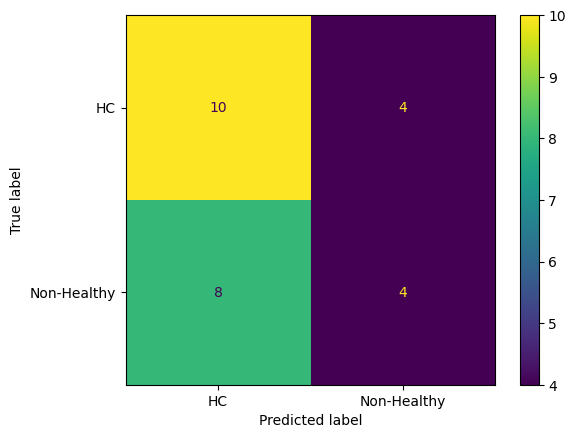

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.581
f1: 0.579
precision: 0.579
recall: 0.580


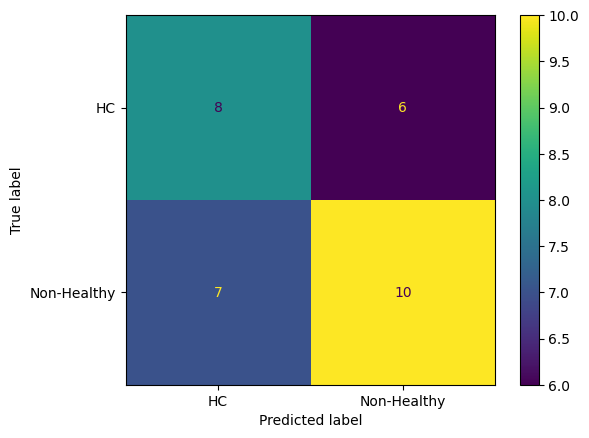

Non-healthy train indices: [0, 1, 3, 12, 16, 17, 20, 21]
Non-healthy dev indices: [0, 1, 7, 8, 9, 11, 13, 14, 15, 16, 17, 21, 22, 24, 26, 30]
Training base model for MCI vs. Dementia...
Setting batch size to  4
Epoch 0, Loss: 0.00000


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.00000
Epoch 100, Loss: 0.00000
Epoch 150, Loss: 0.00000
Epoch 200, Loss: 0.00000
Validating on meta model dev set...
Setting batch size to  8
accuracy: 0.875
f1: 0.467
precision: 0.438
recall: 0.500


C:\Users\Student\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


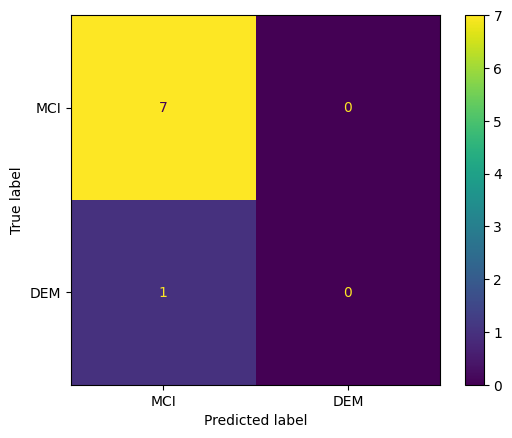

----------- Task: SFT -----------
Training base model for Healthy vs. Non-Healthy...
Setting batch size to  100
Epoch 0, Loss: 3.74109


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.46846
Epoch 100, Loss: 0.05357
Epoch 150, Loss: 0.00562
Epoch 200, Loss: 0.00234
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.654
f1: 0.627
precision: 0.673
recall: 0.637


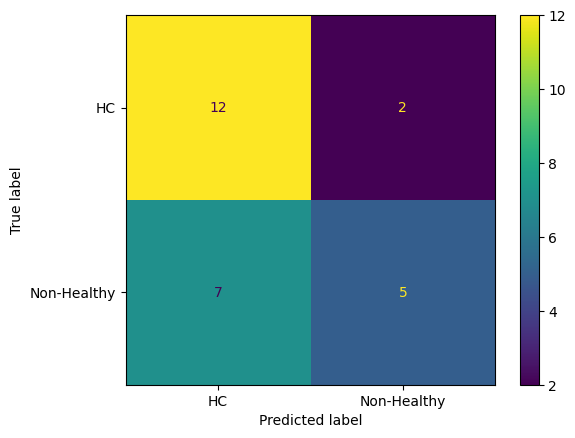

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.355
f1: 0.349
precision: 0.357
recall: 0.368


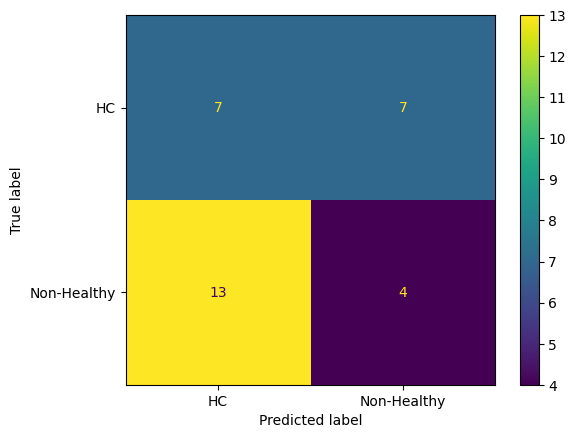

Non-healthy train indices: [3, 12, 13, 14, 16, 19, 22]
Non-healthy dev indices: [0, 3, 4, 5, 9, 14, 15, 17, 22, 24, 30]
Training base model for MCI vs. Dementia...
Setting batch size to  5
Epoch 0, Loss: 0.00000


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.00000
Epoch 100, Loss: 0.00000
Epoch 150, Loss: 0.00000
Epoch 200, Loss: 0.00000
Validating on meta model dev set...
Setting batch size to  4
accuracy: 0.750
f1: 0.429
precision: 0.375
recall: 0.500


C:\Users\Student\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


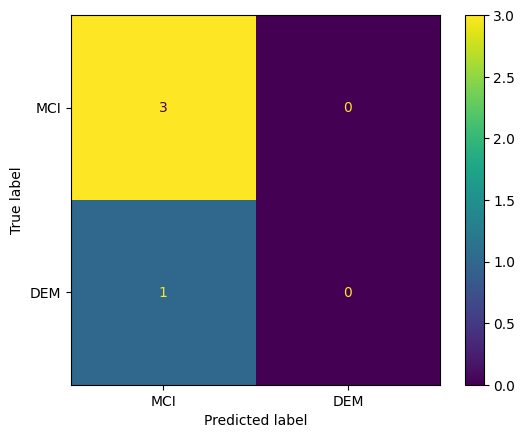

----------- Task: PFT -----------
Training base model for Healthy vs. Non-Healthy...
Setting batch size to  100
Epoch 0, Loss: 3.82802


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.24065
Epoch 100, Loss: 0.00433
Epoch 150, Loss: 0.00122
Epoch 200, Loss: 0.00067
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.577
f1: 0.576
precision: 0.577
recall: 0.577


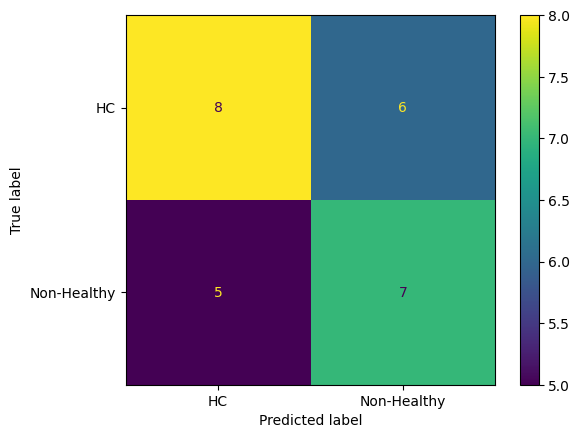

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.516
f1: 0.514
precision: 0.515
recall: 0.515


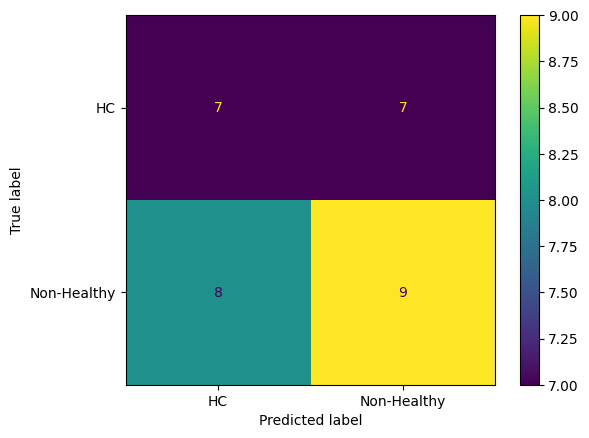

Non-healthy train indices: [0, 1, 3, 4, 7, 9, 11, 13, 16, 19, 20, 21, 22]
Non-healthy dev indices: [2, 4, 6, 11, 14, 16, 18, 19, 20, 21, 22, 24, 26, 27, 28, 30]
Training base model for MCI vs. Dementia...
Setting batch size to  7
Epoch 0, Loss: 0.73472


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.00000
Epoch 100, Loss: 0.00000
Epoch 150, Loss: 0.00000
Epoch 200, Loss: 0.00000
Validating on meta model dev set...
Setting batch size to  8
accuracy: 0.875
f1: 0.467
precision: 0.438
recall: 0.500


C:\Users\Student\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


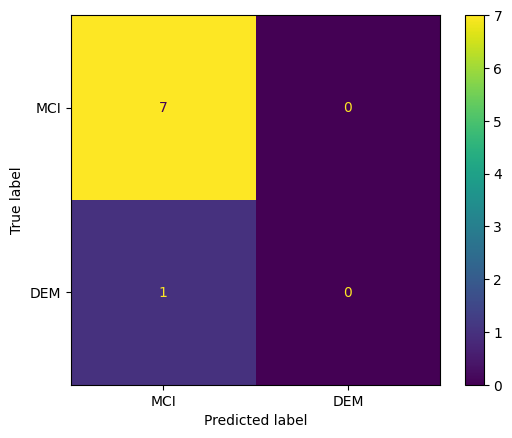

Fold 3:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 48}),
    train set for meta model: 26 samples; label count: Counter({0: 13, 1: 13}),
    dev set for meta model: 31 samples; label count: Counter({0: 17, 1: 14})
----------- Task: CTD -----------
Training base model for Healthy vs. Non-Healthy...
Setting batch size to  100
Epoch 0, Loss: 3.87458


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.57163
Epoch 100, Loss: 0.24678
Epoch 150, Loss: 0.03884
Epoch 200, Loss: 0.00781
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.615
f1: 0.613
precision: 0.618
recall: 0.615


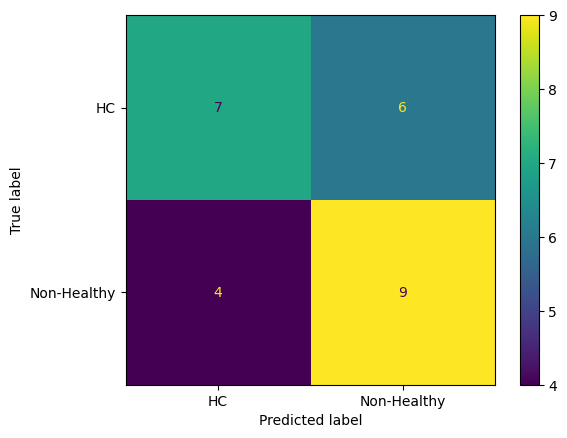

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.548
f1: 0.548
precision: 0.550
recall: 0.550


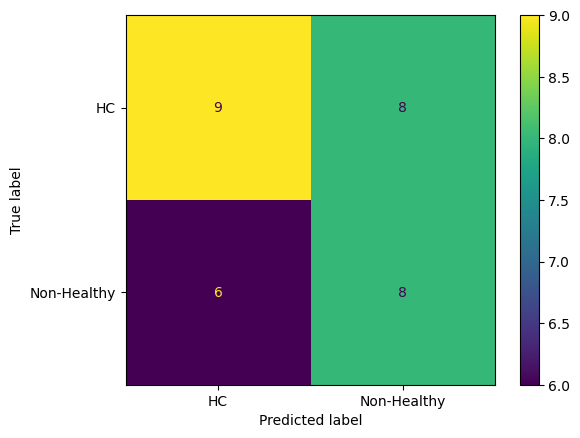

Non-healthy train indices: [0, 2, 3, 5, 6, 7, 8, 12, 13, 14, 15, 17, 18, 19, 21]
Non-healthy dev indices: [0, 1, 4, 7, 9, 10, 11, 14, 15, 18, 20, 21, 25, 26, 27, 28]
Training base model for MCI vs. Dementia...
Setting batch size to  9
Epoch 0, Loss: 0.71991


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.00004
Epoch 100, Loss: 0.00001
Epoch 150, Loss: 0.00001
Epoch 200, Loss: 0.00000
Validating on meta model dev set...
Setting batch size to  8
accuracy: 0.625
f1: 0.385
precision: 0.312
recall: 0.500


C:\Users\Student\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


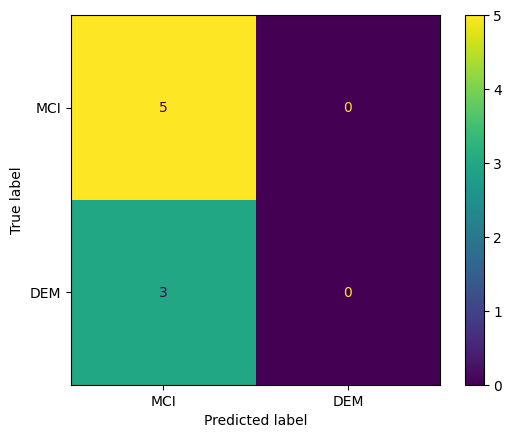

----------- Task: SFT -----------
Training base model for Healthy vs. Non-Healthy...
Setting batch size to  100
Epoch 0, Loss: 3.73390


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.47304
Epoch 100, Loss: 0.07430
Epoch 150, Loss: 0.00607
Epoch 200, Loss: 0.00232
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.500
f1: 0.493
precision: 0.500
recall: 0.500


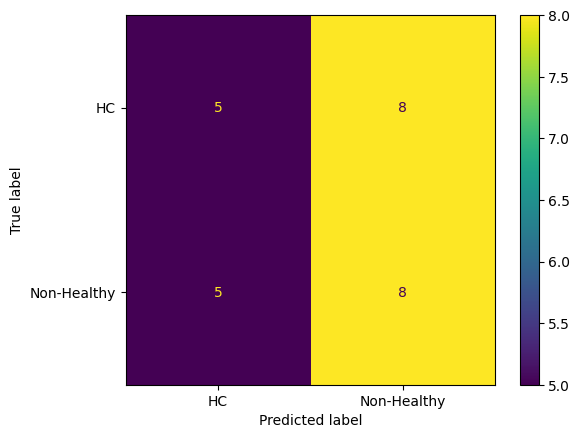

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.516
f1: 0.514
precision: 0.515
recall: 0.515


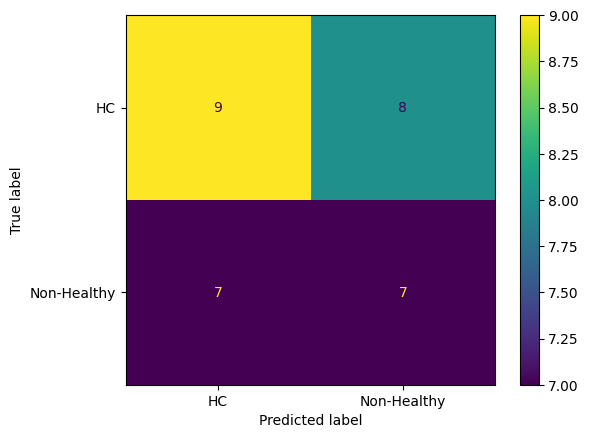

Non-healthy train indices: [0, 4, 5, 6, 7, 8, 9, 11, 14, 16, 18, 20, 21, 22, 24, 25]
Non-healthy dev indices: [2, 8, 9, 12, 15, 17, 19, 20, 21, 22, 23, 24, 26, 28, 29]
Training base model for MCI vs. Dementia...
Setting batch size to  8
Epoch 0, Loss: 1.37565


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.00004
Epoch 100, Loss: 0.00001
Epoch 150, Loss: 0.00001
Epoch 200, Loss: 0.00000
Validating on meta model dev set...
Setting batch size to  5
accuracy: 0.800
f1: 0.444
precision: 0.400
recall: 0.500


C:\Users\Student\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


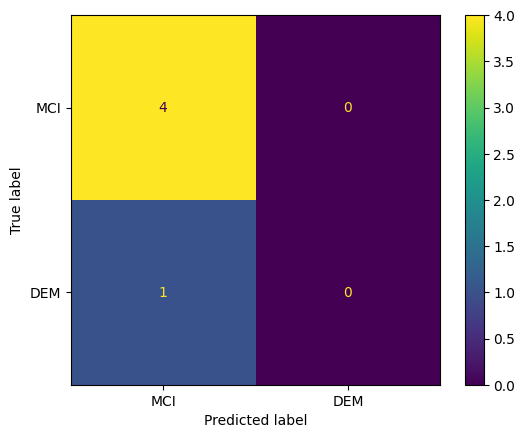

----------- Task: PFT -----------
Training base model for Healthy vs. Non-Healthy...
Setting batch size to  100
Epoch 0, Loss: 3.81139


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.18618
Epoch 100, Loss: 0.00344
Epoch 150, Loss: 0.00114
Epoch 200, Loss: 0.00064
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.577
f1: 0.576
precision: 0.577
recall: 0.577


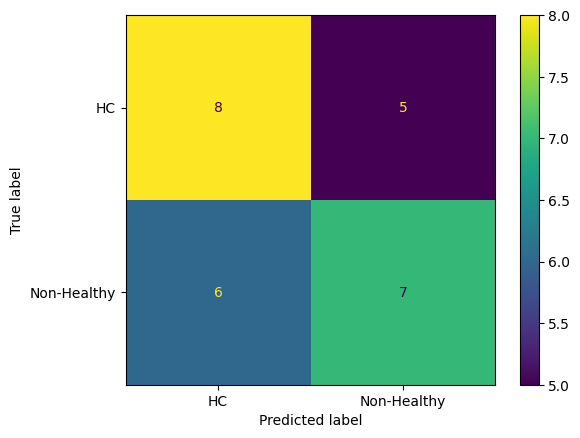

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.470
precision: 0.471
recall: 0.473


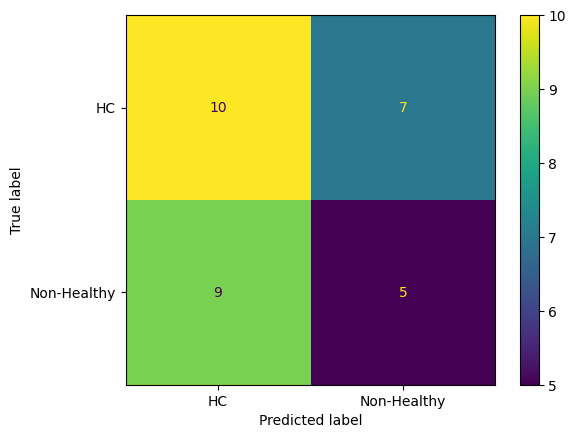

Non-healthy train indices: [1, 3, 4, 5, 6, 8, 9, 15, 18, 20, 22, 25]
Non-healthy dev indices: [0, 3, 4, 5, 10, 15, 16, 20, 23, 26, 28, 30]
Training base model for MCI vs. Dementia...
Setting batch size to  7
Epoch 0, Loss: 1.09129


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.00000
Epoch 100, Loss: 0.00000
Epoch 150, Loss: 0.00000
Epoch 200, Loss: 0.00000
Validating on meta model dev set...
Setting batch size to  6
accuracy: 0.500
f1: 0.333
precision: 0.300
recall: 0.375


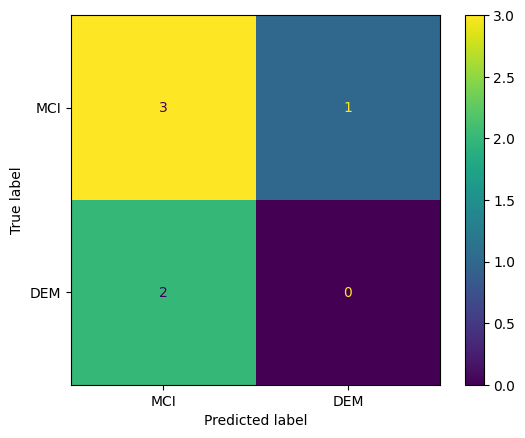

Fold 4:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 48}),
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 12}),
    dev set for meta model: 31 samples; label count: Counter({0: 16, 1: 15})
----------- Task: CTD -----------
Training base model for Healthy vs. Non-Healthy...
Setting batch size to  100
Epoch 0, Loss: 3.68456


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.55826
Epoch 100, Loss: 0.30812
Epoch 150, Loss: 0.07753
Epoch 200, Loss: 0.01284
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.462
f1: 0.462
precision: 0.464
recall: 0.464


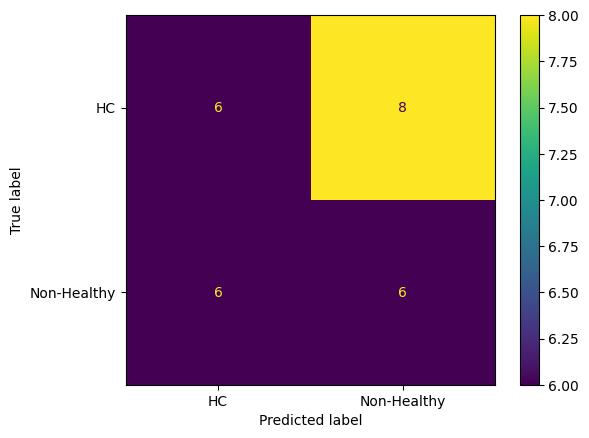

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.449
precision: 0.450
recall: 0.450


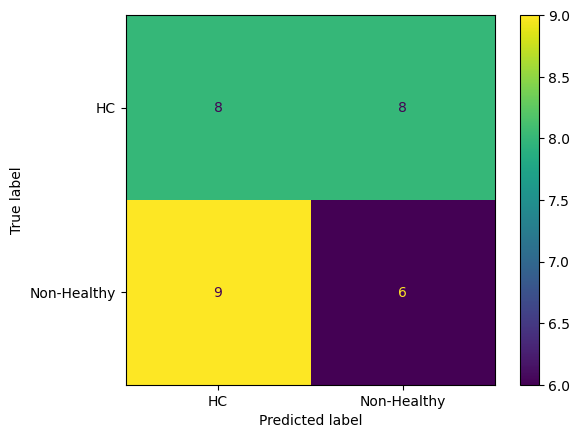

Non-healthy train indices: [1, 2, 5, 7, 9, 10, 12, 14, 15, 17, 19, 22, 23, 25]
Non-healthy dev indices: [0, 1, 3, 5, 9, 12, 14, 15, 16, 17, 21, 23, 26, 30]
Training base model for MCI vs. Dementia...
Setting batch size to  6
Epoch 0, Loss: 1.38091


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.00008
Epoch 100, Loss: 0.00003
Epoch 150, Loss: 0.00003
Epoch 200, Loss: 0.00002
Validating on meta model dev set...
Setting batch size to  9
accuracy: 0.556
f1: 0.550
precision: 0.575
recall: 0.583


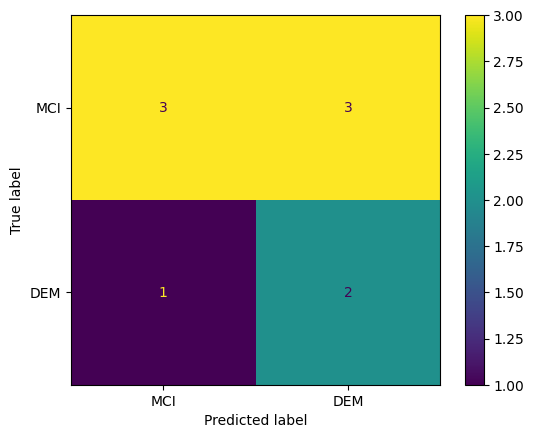

----------- Task: SFT -----------
Training base model for Healthy vs. Non-Healthy...
Setting batch size to  100
Epoch 0, Loss: 3.68856


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.51945
Epoch 100, Loss: 0.11092
Epoch 150, Loss: 0.00698
Epoch 200, Loss: 0.00253
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.500
f1: 0.493
precision: 0.494
recall: 0.494


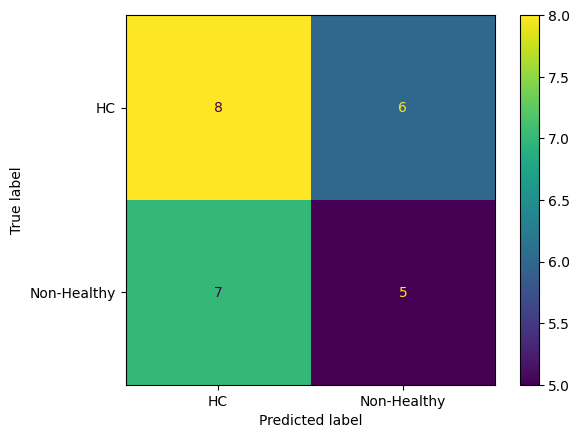

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.581
f1: 0.581
precision: 0.581
recall: 0.581


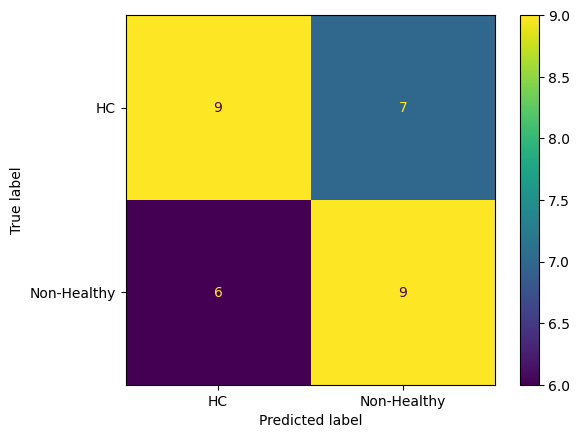

Non-healthy train indices: [0, 2, 5, 6, 9, 10, 11, 12, 18, 20, 23]
Non-healthy dev indices: [1, 2, 3, 5, 11, 13, 14, 15, 16, 17, 18, 21, 22, 25, 27, 29]
Training base model for MCI vs. Dementia...
Setting batch size to  5
Epoch 0, Loss: 0.74232


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.00000
Epoch 100, Loss: 0.00000
Epoch 150, Loss: 0.00000
Epoch 200, Loss: 0.00000
Validating on meta model dev set...
Setting batch size to  8
accuracy: 0.625
f1: 0.385
precision: 0.312
recall: 0.500


C:\Users\Student\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


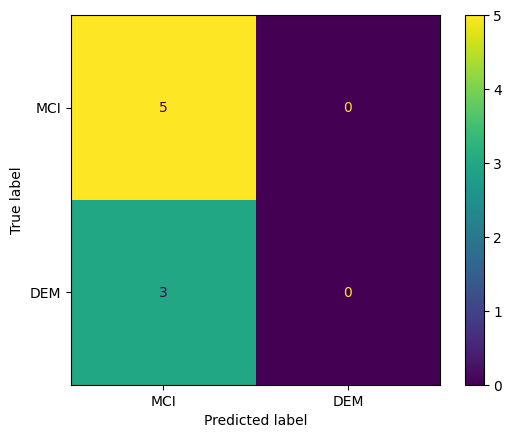

----------- Task: PFT -----------
Training base model for Healthy vs. Non-Healthy...
Setting batch size to  100
Epoch 0, Loss: 3.79032


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.20998
Epoch 100, Loss: 0.00298
Epoch 150, Loss: 0.00102
Epoch 200, Loss: 0.00058
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.692
f1: 0.685
precision: 0.694
recall: 0.685


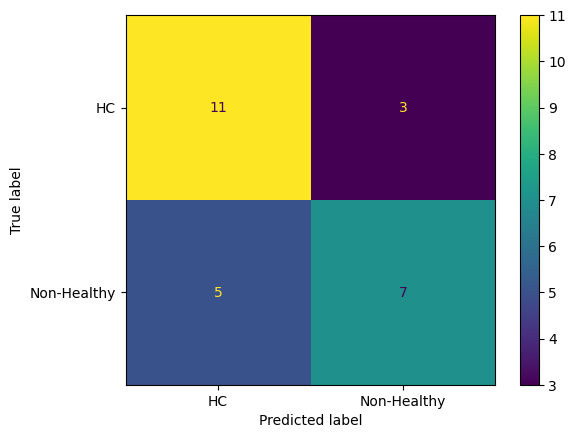

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.452
precision: 0.452
recall: 0.452


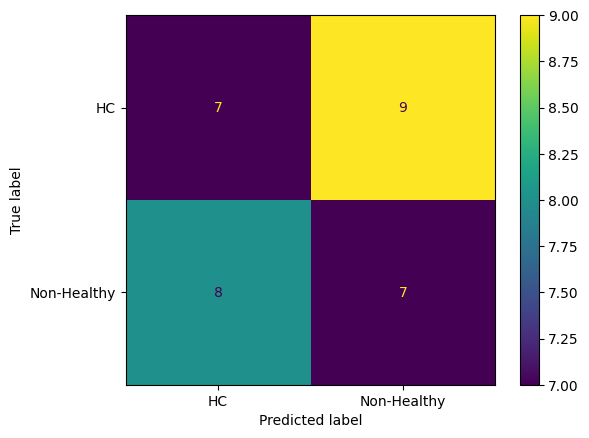

Non-healthy train indices: [1, 2, 4, 5, 11, 14, 16, 19, 23, 24]
Non-healthy dev indices: [0, 1, 4, 5, 7, 13, 14, 16, 17, 19, 20, 21, 25, 27, 28, 29]
Training base model for MCI vs. Dementia...
Setting batch size to  7
Epoch 0, Loss: 1.08556


C:\Users\Student\AppData\Local\Temp\ipykernel_22652\2721558618.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = cross_entropy(out, torch.tensor(batch.y, dtype=torch.long, device=out.device))


Epoch 50, Loss: 0.00002
Epoch 100, Loss: 0.00001
Epoch 150, Loss: 0.00000
Epoch 200, Loss: 0.00000
Validating on meta model dev set...
Setting batch size to  9
accuracy: 0.667
f1: 0.400
precision: 0.375
recall: 0.429


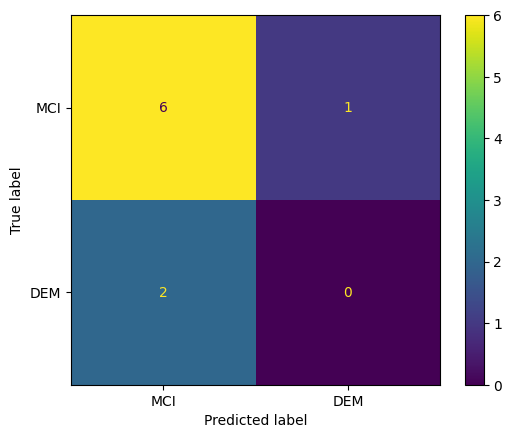

In [55]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TASKS = ['CTD', 'SFT', 'PFT']
LABEL_MAPPING_STAGE1 = {'HC': 0, 'MCI': 1, 'Dementia': 1}  # Healthy vs. Non-Healthy
LABEL_MAPPING_STAGE2 = {'MCI': 0, 'Dementia': 1}  # MCI vs. Dementia

# Load and shuffle metadata
metadata = pd.read_csv("PROCESS_METADATA_ALL.csv")
metadata = metadata.sample(frac=1, random_state=42, ignore_index=False)
metadata['diagnosis_coded_stage1'] = metadata['diagnosis'].map(LABEL_MAPPING_STAGE1)
metadata['diagnosis_coded_stage2'] = metadata['diagnosis'].map(LABEL_MAPPING_STAGE2).fillna(-1).astype(int)

# Prepare training and development data
df_traindev = metadata[metadata['Tr/Tt/Dv'].isin(['train', 'dev'])]
id_traindev, label_traindev_stage1 = df_traindev['anyon_IDs'], df_traindev['diagnosis_coded_stage1']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf_dict = defaultdict(dict)

for fold_index, (train_index, dev_index) in enumerate(skf.split(id_traindev, label_traindev_stage1)):
    print(f"Fold {fold_index}:")
    base_train_id, ensemble_train_id, base_train_label, ensemble_train_label = train_test_split(id_traindev[train_index], label_traindev_stage1[train_index],
                                                        stratify=label_traindev_stage1[train_index],
                                                        test_size=0.2)
    print(f'''
    train set for base model: {len(base_train_label)} samples; label count: {Counter(base_train_label)},
    train set for meta model: {len(ensemble_train_label)} samples; label count: {Counter(ensemble_train_label)},
    dev set for meta model: {len(label_traindev_stage1[dev_index])} samples; label count: {Counter(label_traindev_stage1[dev_index])}''')

    logits_for_ensemble_training = []
    pred_for_ensemble_training = []

    logits_for_ensemble_validation = []
    pred_for_ensemble_validation = []

    for task in TASKS:
        print(f'----------- Task: {task} -----------')
        transcript_folder = os.path.join("transcripts_outputFiles", f"{task}_outputFiles")
        # Ensure the directory exists
        if not os.path.exists(transcript_folder):
            os.makedirs(transcript_folder)
        base_train_datalist = get_datalist(base_train_id, base_train_label, transcript_folder)
        ensemble_train_datalist = get_datalist(ensemble_train_id, ensemble_train_label, transcript_folder)
        ensemble_dev_datalist = get_datalist(id_traindev[dev_index], label_traindev_stage1[dev_index], transcript_folder)
        
        # Training GNN for Healthy vs. Non-Healthy classification
        print('Training base model for Healthy vs. Non-Healthy...')
        trained_gnn_stage1 = train_gnn(base_train_datalist)
        
        # Get predictions for meta-model training
        print('Validating on meta model train set...')
        task_logits_ensemble_training, task_pred_ensemble_training, _, _ = eval_gnn(trained_gnn_stage1, ensemble_train_datalist, stage_labels= ['HC', 'Non-Healthy'], print_results=False)
        logits_for_ensemble_training.append(task_logits_ensemble_training)
        pred_for_ensemble_training.append(task_pred_ensemble_training)
        
        # Get predictions for meta-model validation
        print('Validating on meta model dev set...')
        task_logits_ensemble_validation, task_pred_ensemble_validation, _, _ = eval_gnn(trained_gnn_stage1, ensemble_dev_datalist, stage_labels= ['HC', 'Non-Healthy'], print_results=False)
        logits_for_ensemble_validation.append(task_logits_ensemble_validation)
        pred_for_ensemble_validation.append(task_pred_ensemble_validation)
        
        # Filter non-healthy participants for the second stage
        non_healthy_train_indices = [i for i, pred in enumerate(task_pred_ensemble_training) if pred == 1]
        non_healthy_dev_indices = [i for i, pred in enumerate(task_pred_ensemble_validation) if pred == 1]
        
        print(f'Non-healthy train indices: {non_healthy_train_indices}')
        print(f'Non-healthy dev indices: {non_healthy_dev_indices}')
        
        # Filter out any IDs whose stage 2 labels are not valid (i.e., NaN or -1)
        valid_non_healthy_train = [
            (id, df_traindev.loc[df_traindev['anyon_IDs'] == id, 'diagnosis_coded_stage2'].values[0])
            for id in ensemble_train_id.iloc[non_healthy_train_indices]
            if df_traindev.loc[df_traindev['anyon_IDs'] == id, 'diagnosis_coded_stage2'].values[0] in [0, 1]
        ]

        non_healthy_train_ids, non_healthy_train_labels = zip(*valid_non_healthy_train) if valid_non_healthy_train else ([], [])
        
        # Filter out invalid stage 2 labels for dev set
        valid_non_healthy_dev = [
            (id, df_traindev.loc[df_traindev['anyon_IDs'] == id, 'diagnosis_coded_stage2'].values[0])
            for id in id_traindev.iloc[dev_index].iloc[non_healthy_dev_indices]
            if df_traindev.loc[df_traindev['anyon_IDs'] == id, 'diagnosis_coded_stage2'].values[0] in [0, 1]
        ]

        non_healthy_dev_ids, non_healthy_dev_labels = zip(*valid_non_healthy_dev) if valid_non_healthy_dev else ([], [])
        
        # Prepare data for the second stage
        non_healthy_train_datalist = get_datalist(non_healthy_train_ids, non_healthy_train_labels, transcript_folder)
        non_healthy_dev_datalist = get_datalist(non_healthy_dev_ids, non_healthy_dev_labels, transcript_folder)
        
        # Training GNN for MCI vs. Dementia classification
        print('Training base model for MCI vs. Dementia...')
        if not non_healthy_train_ids:
            print("No valid non-healthy train samples available. Skipping Stage 2 training.")
        else:
            trained_gnn_stage2 = train_gnn(non_healthy_train_datalist)
        
        # Evaluate the second stage model
        print('Validating on meta model dev set...')
        _, _, kf_dict[fold_index][f'{task}_gnn_stage2_results'], kf_dict[fold_index][f'{task}_gnn_stage2_cm_disp'] = eval_gnn(trained_gnn_stage2, non_healthy_dev_datalist, stage_labels= ['MCI', 'DEM'])
        
    kf_dict[fold_index]['logits_for_ensemble_training'] = logits_for_ensemble_training
    kf_dict[fold_index]['logits_for_ensemble_validation'] = logits_for_ensemble_validation
    kf_dict[fold_index]['pred_for_ensemble_training'] = pred_for_ensemble_training
    kf_dict[fold_index]['pred_for_ensemble_validation'] = pred_for_ensemble_validation
    kf_dict[fold_index]['ensemble_train_label'] = ensemble_train_label
    kf_dict[fold_index]['ensemble_dev_label'] = label_traindev_stage1[dev_index]